In [117]:
##Based on this article:
##https://keras.io/examples/timeseries/timeseries_classification_from_scratch/#setup


#import sys
#!{sys.executable} -m pip install tensorflow
from tensorflow import keras
from tensorflow import math
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [118]:
import json
# Opening JSON file with labels. 
#the key is a combination of long - lat and the value is either 0 or 1. 
#The labels are created based on data from bleaching DB where % bleaching > 60 % == 1 else 0. 
#A label is from the latest sample of that location
#The coordinates is the coordinates found in the sea sureface temperature dataset, 
#and is not always an exact match to the cordinates found in Bleaching DB (the values were rounded to 1 decimal to find matches in both datasets). 
f = open('/home/jovyan/Ocean Data Platform Tutorials/data/NOAA Coral Reef Watch/label_dict2.json',)
target_dict = json.load(f)
f.close()

In [88]:
#read all csv files to get min and max values of all timeseries
#NaNs are treated as missing values: disregarded in fit, and maintained in transform.

c = 0
min_row = 9999999
filenameset = set()
os.chdir("../test_data2")
for file in glob.glob("*.csv"):
    if file.split("_")[-1] != "M.csv":
        df = pd.read_csv(file, header=0)
        #print (df)
        values = df['0']
        min_row = values.shape[0] if values.shape[0] < min_row else min_row
        filename = file.replace("-Copy1","").replace("-Copy2","").replace("-Copy3","").rstrip(".csv").rstrip("_M")
        if filename in target_dict:
            if filename in filenameset:
                continue

            if c > 0:
                s1 = pd.concat([s1, values], ignore_index=True)
              
            else:
                s1 = values
            filenameset.add(filename)
            c +=1

In [89]:
min_row

7306

In [91]:
#Standardize time series data
#Rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.
values = s1.values
values = values.reshape((len(values), 1))
#Train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))

Mean: 27.960987, StandardDeviation: 1.094260


In [93]:
sequences = list()
targets = list()
sequences2 = list()
targets2 = list()
os.chdir("../test_data2")
filenameset = set()

#Training data: daily sea surface temperature timeseries from 2000-2020 for given locations

for file in glob.glob("*.csv"):
    if file.split("_")[-1] != "M.csv":
        df = pd.read_csv(file, header=0)
        df = df.iloc[:min_row]
        values = df['0'].fillna(0)
        #print(df.shape[0])
        values = values.values
        #print(values)
        values = values.reshape((len(values), 1))
        #values = values.reshape(-1, 1)
        filename = file.replace("-Copy1","").replace("-Copy2","").replace("-Copy3","").rstrip(".csv").rstrip("_M")
        if filename in target_dict:
            if filename in filenameset:
                continue
            #seperated in 2 list, to create a balanced training set
            if target_dict[filename] == 0:
                sequences2.append(np.array(scaler.transform(values)))
                targets2.append(target_dict[filename])
            else:
                targets.append(target_dict[filename])
                sequences.append(np.array(scaler.transform(values)))
                
            filenameset.add(filename)
            

In [94]:
len(sequences)

196

In [95]:
sequences2[0].shape

(7306, 1)

In [96]:
train_len = round(len(targets) * 0.9)
test_len = len(targets)-train_len

In [97]:
train = [sequences[i] for i in range(0,train_len)] + [sequences2[i] for i in range(0,train_len)] #equal amount of 1s and 0s to balance the training set
test = [sequences[i] for i in range(train_len,train_len+test_len)]+ [sequences2[i] for i in range(train_len,train_len+test_len+10)]

train_target = [targets[i] for i in range(0, train_len)] + [targets2[i] for i in range(0,train_len)]
test_target = [targets[i] for i in range(train_len,train_len+test_len)] + [targets2[i] for i in range(train_len,train_len+test_len+10)]

In [98]:
x_train = np.array(train)
x_test = np.array(test)
y_train = np.array(train_target)
y_test = np.array(test_target)

In [99]:
x_train.shape

(352, 7306, 1)

0
1


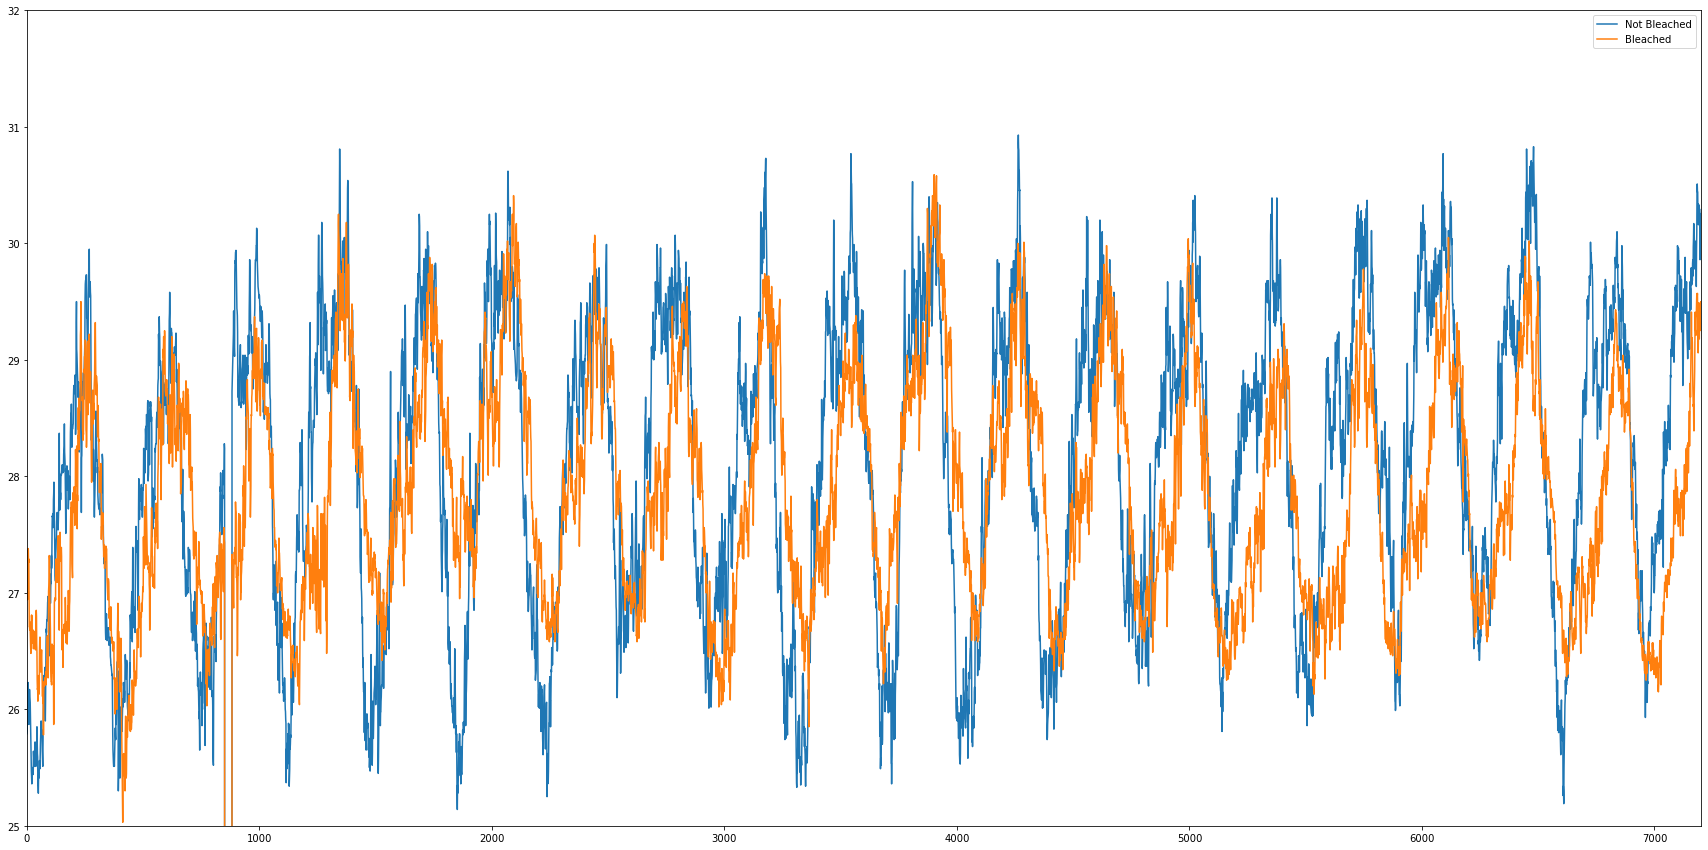

In [101]:
#Visualize 1 timeseries example for each class (bleaching vs no bleaching).

classes = np.unique(np.concatenate((y_train, y_test), axis=0))
plt.figure(figsize=(30,15))
for c in classes:
    print(c)
    c_x_train = x_train[y_train == c]
    plt.plot(scaler.inverse_transform(c_x_train[0]), label="Bleached" if c == 1 else "Not Bleached")
    
plt.legend(loc="best")
ax=plt.gca()
ax.axis([0,7200,25,32])
plt.show()
plt.close()

In [102]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [103]:
num_classes = len(np.unique(y_train))

In [104]:
#Shuffle training set the last X % of the training set will be used as validation on model (X is defined in validation_split option).
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [105]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=10, padding="same")(input_layer)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.BatchNormalization(axis=1)(conv1)

    conv2 = keras.layers.Conv1D(filters=128, kernel_size=10, padding="same")(conv1)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.BatchNormalization(axis=1)(conv2)

    conv3 = keras.layers.Conv1D(filters=128, kernel_size=10, padding="same")(conv2)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.BatchNormalization(axis=1)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [106]:
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [107]:
epochs = 200
batch_size = 5
adam = Adam(lr=0.005)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.05, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=adam,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200


/srv/conda/envs/notebook/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


57/57 [==============================] - 80s 1s/step - loss: 0.9117 - sparse_categorical_accuracy: 0.5552 - val_loss: 1.0194 - val_sparse_categorical_accuracy: 0.6479 - lr: 0.0050
Epoch 2/200
57/57 [==============================] - 78s 1s/step - loss: 0.6935 - sparse_categorical_accuracy: 0.5730 - val_loss: 0.6965 - val_sparse_categorical_accuracy: 0.5211 - lr: 0.0050
Epoch 3/200
57/57 [==============================] - 78s 1s/step - loss: 0.6746 - sparse_categorical_accuracy: 0.6014 - val_loss: 0.7061 - val_sparse_categorical_accuracy: 0.4648 - lr: 0.0050
Epoch 4/200
57/57 [==============================] - 77s 1s/step - loss: 0.7282 - sparse_categorical_accuracy: 0.5196 - val_loss: 0.7086 - val_sparse_categorical_accuracy: 0.5352 - lr: 0.0050
Epoch 5/200
57/57 [==============================] - 78s 1s/step - loss: 0.6674 - sparse_categorical_accuracy: 0.6192 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.5915 - lr: 0.0050
Epoch 6/200
57/57 [==============================] -

In [108]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 3s 1s/step - loss: 0.4129 - sparse_categorical_accuracy: 0.8800
Test accuracy 0.8799999952316284
Test loss 0.412894606590271


In [111]:
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [112]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0])

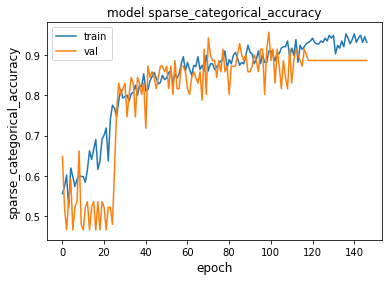

In [114]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

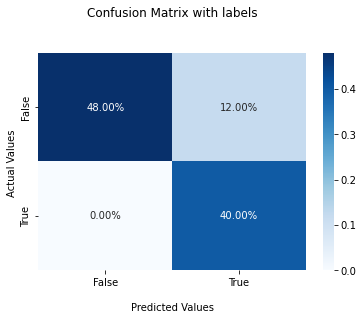

In [119]:
# import sys
# !{sys.executable} -m pip install seaborn
import seaborn as sns
cf_matrix = math.confusion_matrix(y_test, y_pred)

#count
#ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

#%
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()